# Notebook 03 — Prepare for Modeling

Process **all 4 datasets** produced by Notebook 02 through two independent modeling pipelines:

| Target | Task | Notes |
|---|---|---|
| `is_profitable` | Binary classification | `roi` dropped (leakage) |
| `vote_average` | Regression | `vote_average` is the target |

| Dataset | Key | Sources |
|---|---|---|
| Metadata Only | `metadata` | movies_metadata |
| Meta + Credits | `meta_credits` | movies_metadata + credits |
| Meta + Keywords | `meta_keywords` | movies_metadata + keywords |
| All Combined | `all` | all three |

Steps per pipeline per dataset: feature selection → one-hot encoding → train/test split → scaling → baseline model.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, mean_squared_error,
                             mean_absolute_error, r2_score)

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
print("Libraries loaded.")

Libraries loaded.


## 1 · Load All Datasets

In [3]:
DATASETS = {
    'metadata': {
        'path': '../data/processed/movies_processed_metadata.csv',
        'label': 'Metadata Only',
        'out_dir': '../data/processed/metadata',
    },
    'meta_credits': {
        'path': '../data/processed/movies_processed_meta_credits.csv',
        'label': 'Metadata + Credits',
        'out_dir': '../data/processed/meta_credits',
    },
    'meta_keywords': {
        'path': '../data/processed/movies_processed_meta_keywords.csv',
        'label': 'Metadata + Keywords',
        'out_dir': '../data/processed/meta_keywords',
    },
    'all': {
        'path': '../data/processed/movies_processed.csv',
        'label': 'All Combined',
        'out_dir': '../data/processed/all',
    },
}

loaded = {}
for key, info in DATASETS.items():
    loaded[key] = pd.read_csv(info['path'])
    loaded[key]['is_profitable'] = (loaded[key]['roi'] > 0).astype(int)
    shape = loaded[key].shape
    pct = loaded[key]['is_profitable'].mean() * 100
    print(f"{info['label']:20s}  {shape[0]:,} rows x {shape[1]} cols  |  {pct:.1f}% profitable")

Metadata Only         5,352 rows x 18 cols  |  69.9% profitable
Metadata + Credits    5,352 rows x 24 cols  |  69.9% profitable
Metadata + Keywords   5,352 rows x 19 cols  |  69.9% profitable
All Combined          5,352 rows x 25 cols  |  69.9% profitable


In [4]:
# Quick comparison of all 4 datasets
comp_rows = []
for key, info in DATASETS.items():
    df = loaded[key]
    comp_rows.append({
        'Dataset': info['label'],
        'Rows': len(df),
        'Features': df.shape[1],
        'Profitable %': round(df['is_profitable'].mean() * 100, 1),
        'vote_avg mean': round(df['vote_average'].mean(), 2),
        'vote_avg std': round(df['vote_average'].std(), 2),
    })
print(pd.DataFrame(comp_rows).to_string(index=False))

            Dataset  Rows  Features  Profitable %  vote_avg mean  vote_avg std
      Metadata Only  5352        18          69.9           6.28           0.9
 Metadata + Credits  5352        24          69.9           6.28           0.9
Metadata + Keywords  5352        19          69.9           6.28           0.9
       All Combined  5352        25          69.9           6.28           0.9


## 2 · Correlation Analysis (All Combined Dataset)

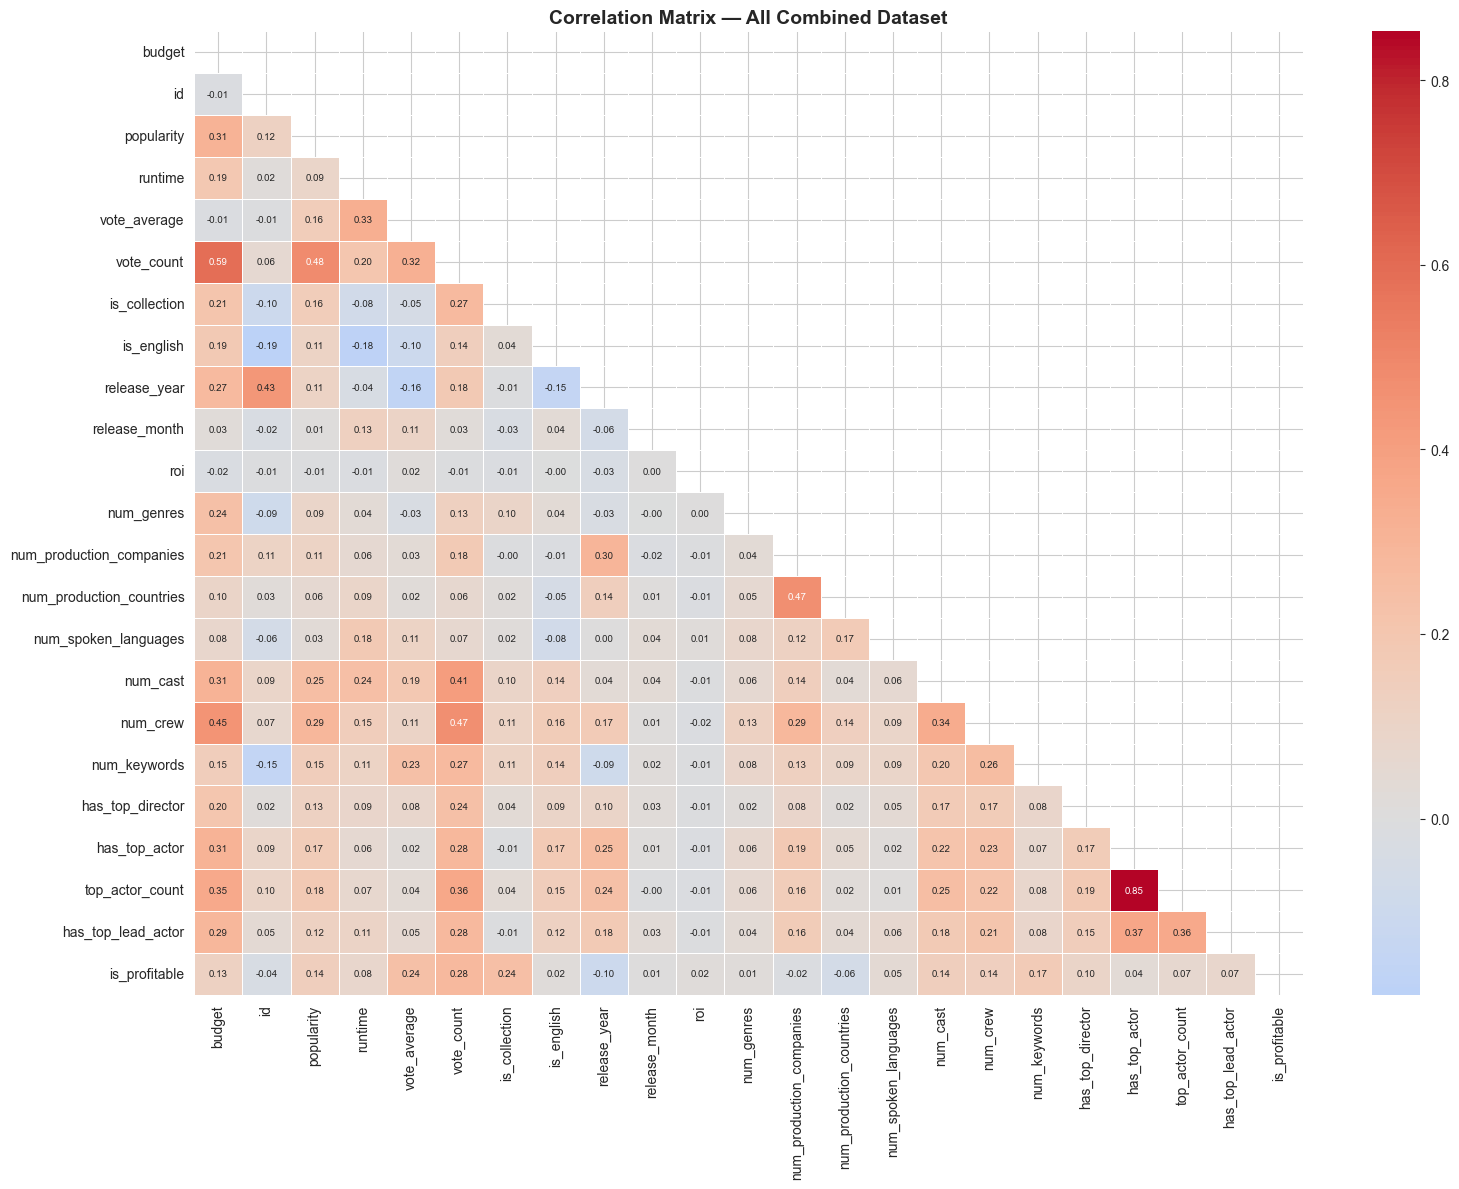

In [5]:
# Correlation heatmap on "all" dataset (most features)
df_corr = loaded['all']
numeric_cols = df_corr.select_dtypes(include='number').columns
corr = df_corr[numeric_cols].corr()

plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, linewidths=0.5, annot_kws={'size': 7})
plt.title('Correlation Matrix — All Combined Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

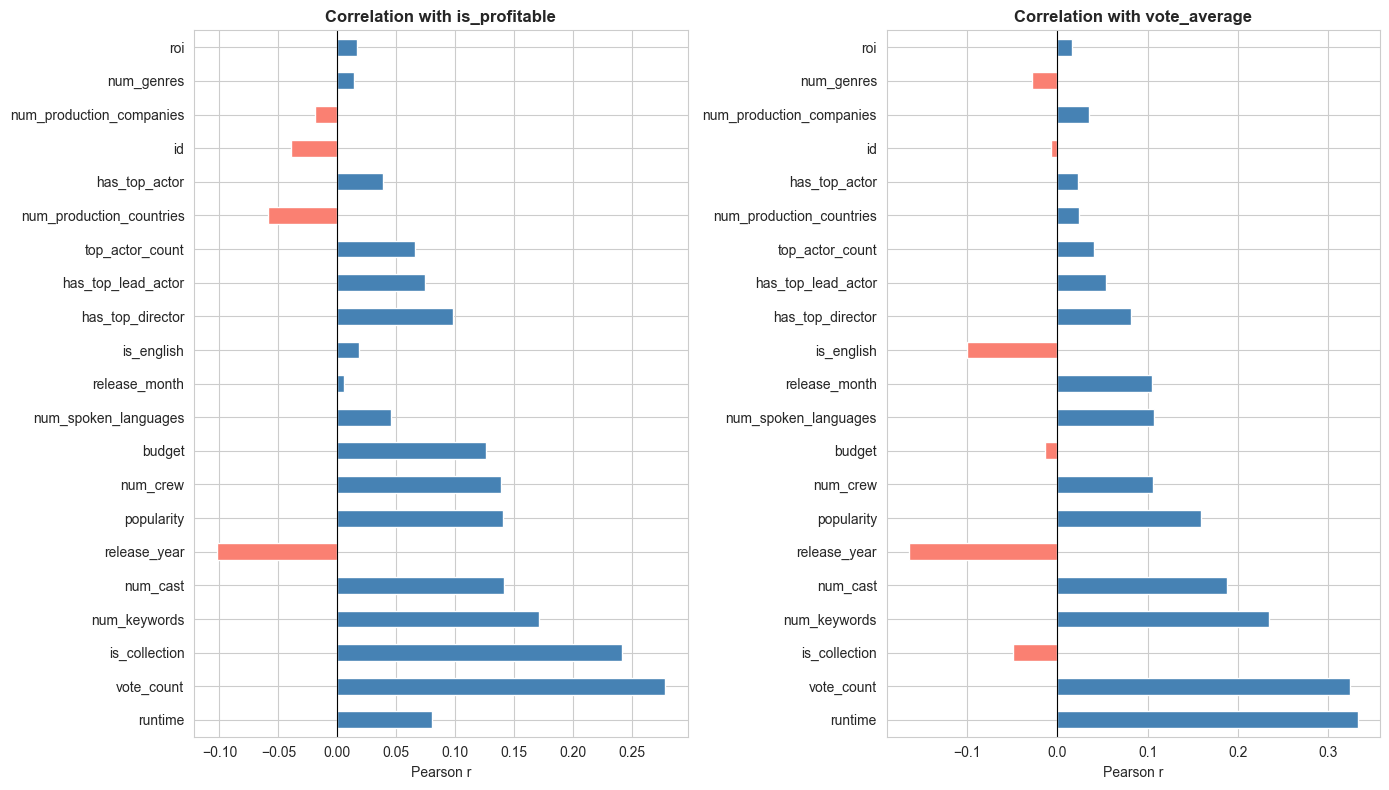

In [6]:
# Correlation with targets
targets = ['is_profitable', 'vote_average']
corr_targets = df_corr[numeric_cols].corr()[targets].drop(targets)
corr_targets = corr_targets.reindex(corr_targets.abs().max(axis=1).sort_values(ascending=False).index)

fig, axes = plt.subplots(1, 2, figsize=(14, 8))
for ax, t in zip(axes, targets):
    corr_targets[t].plot.barh(ax=ax, color=corr_targets[t].apply(
        lambda v: 'steelblue' if v >= 0 else 'salmon'))
    ax.set_title(f'Correlation with {t}', fontsize=12, fontweight='bold')
    ax.axvline(0, color='black', lw=0.8)
    ax.set_xlabel('Pearson r')
plt.tight_layout()
plt.show()

## 3 · Process All Datasets (Encode, Split, Scale, Baseline)

For each dataset:
1. One-hot encode `primary_genre`, drop `id` and `title`
2. **Classification:** drop `roi` (leakage), stratified 80/20 split, StandardScaler, Logistic Regression baseline
3. **Regression:** drop `vote_average` as target, 80/20 split, StandardScaler, Linear Regression baseline
4. Save splits to dataset-specific subdirectory

In [7]:
from collections import OrderedDict
from sklearn.metrics import f1_score

results = OrderedDict()

for ds_key, ds_info in DATASETS.items():
    print(f"\n{'='*80}")
    print(f"  Processing: {ds_info['label']}  ({ds_key})")
    print(f"{'='*80}")

    df = loaded[ds_key].copy()

    # One-hot encode primary_genre
    df_model = pd.get_dummies(df, columns=['primary_genre'], drop_first=True, dtype=int)
    df_model.drop(columns=['id', 'title'], inplace=True, errors='ignore')
    print(f"  Shape after encoding: {df_model.shape}")

    # ---- Classification Pipeline ----
    drop_clf = ['is_profitable', 'roi']
    X_clf = df_model.drop(columns=drop_clf)
    y_clf = df_model['is_profitable']

    X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
        X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf)

    scaler_clf = StandardScaler()
    X_train_clf_sc = pd.DataFrame(
        scaler_clf.fit_transform(X_train_clf),
        columns=X_train_clf.columns, index=X_train_clf.index)
    X_test_clf_sc = pd.DataFrame(
        scaler_clf.transform(X_test_clf),
        columns=X_test_clf.columns, index=X_test_clf.index)

    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_train_clf_sc, y_train_clf)
    y_pred_clf = lr.predict(X_test_clf_sc)
    clf_acc = accuracy_score(y_test_clf, y_pred_clf)
    clf_f1 = f1_score(y_test_clf, y_pred_clf)
    print(f"  CLF Baseline — Accuracy: {clf_acc:.4f}, F1: {clf_f1:.4f}")
    print(f"  CLF Features: {X_clf.shape[1]}, Train: {len(X_train_clf)}, Test: {len(X_test_clf)}")

    # ---- Regression Pipeline ----
    drop_reg = ['vote_average', 'is_profitable']
    X_reg = df_model.drop(columns=[c for c in drop_reg if c in df_model.columns])
    y_reg = df_model['vote_average']

    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
        X_reg, y_reg, test_size=0.2, random_state=42)

    scaler_reg = StandardScaler()
    X_train_reg_sc = pd.DataFrame(
        scaler_reg.fit_transform(X_train_reg),
        columns=X_train_reg.columns, index=X_train_reg.index)
    X_test_reg_sc = pd.DataFrame(
        scaler_reg.transform(X_test_reg),
        columns=X_test_reg.columns, index=X_test_reg.index)

    linreg = LinearRegression()
    linreg.fit(X_train_reg_sc, y_train_reg)
    y_pred_reg = linreg.predict(X_test_reg_sc)
    reg_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
    reg_r2 = r2_score(y_test_reg, y_pred_reg)
    print(f"  REG Baseline — RMSE: {reg_rmse:.4f}, R²: {reg_r2:.4f}")
    print(f"  REG Features: {X_reg.shape[1]}, Train: {len(X_train_reg)}, Test: {len(X_test_reg)}")

    # ---- Save splits ----
    out_dir = ds_info['out_dir']
    os.makedirs(out_dir, exist_ok=True)

    X_train_clf_sc.to_csv(f'{out_dir}/X_train_clf.csv', index=False)
    X_test_clf_sc.to_csv(f'{out_dir}/X_test_clf.csv', index=False)
    y_train_clf.to_csv(f'{out_dir}/y_train_clf.csv', index=False)
    y_test_clf.to_csv(f'{out_dir}/y_test_clf.csv', index=False)

    X_train_reg_sc.to_csv(f'{out_dir}/X_train_reg.csv', index=False)
    X_test_reg_sc.to_csv(f'{out_dir}/X_test_reg.csv', index=False)
    y_train_reg.to_csv(f'{out_dir}/y_train_reg.csv', index=False)
    y_test_reg.to_csv(f'{out_dir}/y_test_reg.csv', index=False)

    # Save scalers
    os.makedirs('../models', exist_ok=True)
    joblib.dump(scaler_clf, f'../models/scaler_clf_{ds_key}.pkl')
    joblib.dump(scaler_reg, f'../models/scaler_reg_{ds_key}.pkl')

    # Save feature names
    pd.Series(X_train_clf.columns.tolist()).to_csv(
        f'{out_dir}/features_clf.csv', index=False, header=['feature'])
    pd.Series(X_train_reg.columns.tolist()).to_csv(
        f'{out_dir}/features_reg.csv', index=False, header=['feature'])

    # Store results
    results[ds_key] = {
        'label': ds_info['label'],
        'n_samples': len(df),
        'n_features_clf': X_clf.shape[1],
        'n_features_reg': X_reg.shape[1],
        'clf_accuracy': clf_acc,
        'clf_f1': clf_f1,
        'reg_rmse': reg_rmse,
        'reg_r2': reg_r2,
        'train_size': len(X_train_clf),
        'test_size': len(X_test_clf),
    }
    print(f"  ✓ Saved to {out_dir}/")


  Processing: Metadata Only  (metadata)
  Shape after encoding: (5352, 35)
  CLF Baseline — Accuracy: 0.7750, F1: 0.8448
  CLF Features: 33, Train: 4281, Test: 1071
  REG Baseline — RMSE: 0.6995, R²: 0.3677
  REG Features: 33, Train: 4281, Test: 1071
  ✓ Saved to ../data/processed/metadata/

  Processing: Metadata + Credits  (meta_credits)
  Shape after encoding: (5352, 41)
  CLF Baseline — Accuracy: 0.7684, F1: 0.8394
  CLF Features: 39, Train: 4281, Test: 1071
  REG Baseline — RMSE: 0.6994, R²: 0.3679
  REG Features: 39, Train: 4281, Test: 1071
  ✓ Saved to ../data/processed/meta_credits/

  Processing: Metadata + Keywords  (meta_keywords)
  Shape after encoding: (5352, 36)
  CLF Baseline — Accuracy: 0.7712, F1: 0.8420
  CLF Features: 34, Train: 4281, Test: 1071
  REG Baseline — RMSE: 0.6882, R²: 0.3880
  REG Features: 34, Train: 4281, Test: 1071
  ✓ Saved to ../data/processed/meta_keywords/

  Processing: All Combined  (all)
  Shape after encoding: (5352, 42)
  CLF Baseline — Accur

## 4 · Baseline Comparison Across Datasets

BASELINE RESULTS ACROSS ALL DATASETS
                             label n_samples n_features_clf n_features_reg clf_accuracy    clf_f1  reg_rmse    reg_r2
Dataset                                                                                                              
metadata             Metadata Only      5352             33             33     0.774977  0.844816  0.699519  0.367664
meta_credits    Metadata + Credits      5352             39             39     0.768441  0.839378  0.699389    0.3679
meta_keywords  Metadata + Keywords      5352             34             34     0.771242  0.842037  0.688187  0.387987
all                   All Combined      5352             40             40     0.768441  0.839586  0.689278  0.386045


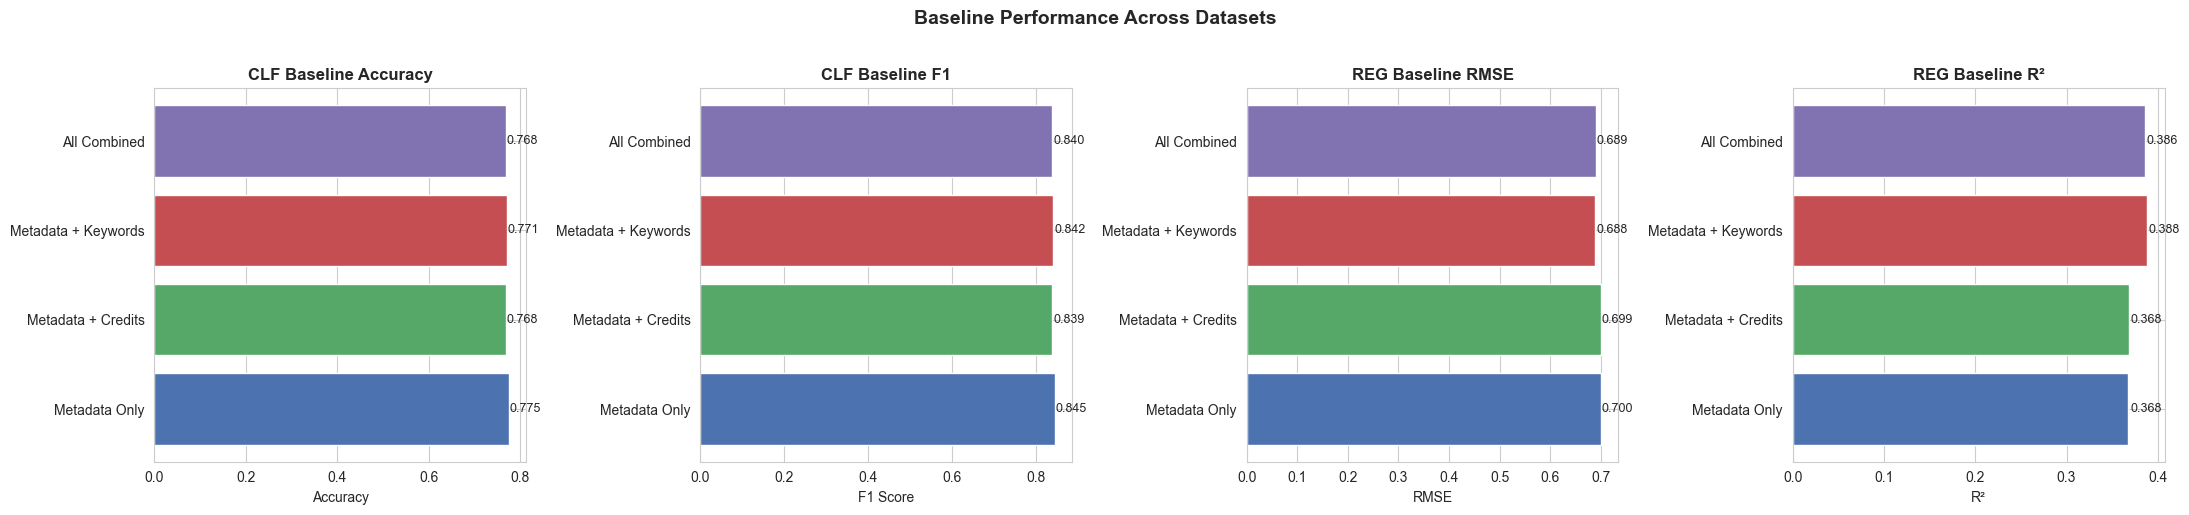

In [8]:
# Summary table
res_df = pd.DataFrame(results).T
res_df.index.name = 'Dataset'

print("BASELINE RESULTS ACROSS ALL DATASETS")
print("=" * 90)
print(res_df[['label', 'n_samples', 'n_features_clf', 'n_features_reg',
              'clf_accuracy', 'clf_f1', 'reg_rmse', 'reg_r2']].to_string())

# Visualization
fig, axes = plt.subplots(1, 4, figsize=(22, 5))
labels = [results[k]['label'] for k in results]
colors = ['#4c72b0', '#55a868', '#c44e52', '#8172b2']

# Classification Accuracy
vals = [results[k]['clf_accuracy'] for k in results]
axes[0].barh(labels, vals, color=colors)
axes[0].set_xlabel('Accuracy')
axes[0].set_title('CLF Baseline Accuracy', fontweight='bold')
for i, v in enumerate(vals):
    axes[0].text(v + 0.002, i, f'{v:.3f}', va='center', fontsize=9)

# Classification F1
vals = [results[k]['clf_f1'] for k in results]
axes[1].barh(labels, vals, color=colors)
axes[1].set_xlabel('F1 Score')
axes[1].set_title('CLF Baseline F1', fontweight='bold')
for i, v in enumerate(vals):
    axes[1].text(v + 0.002, i, f'{v:.3f}', va='center', fontsize=9)

# Regression RMSE
vals = [results[k]['reg_rmse'] for k in results]
axes[2].barh(labels, vals, color=colors)
axes[2].set_xlabel('RMSE')
axes[2].set_title('REG Baseline RMSE', fontweight='bold')
for i, v in enumerate(vals):
    axes[2].text(v + 0.002, i, f'{v:.3f}', va='center', fontsize=9)

# Regression R²
vals = [results[k]['reg_r2'] for k in results]
axes[3].barh(labels, vals, color=colors)
axes[3].set_xlabel('R²')
axes[3].set_title('REG Baseline R²', fontweight='bold')
for i, v in enumerate(vals):
    axes[3].text(v + 0.002, i, f'{v:.3f}', va='center', fontsize=9)

plt.suptitle('Baseline Performance Across Datasets', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [9]:
# Summary of saved artifacts
print("SAVED ARTIFACTS")
print("=" * 70)
for ds_key, ds_info in DATASETS.items():
    out = ds_info['out_dir']
    print(f"\n{ds_info['label']} ({ds_key}):")
    print(f"  Splits : {out}/X_train_clf.csv, X_test_clf.csv, y_train_clf.csv, y_test_clf.csv")
    print(f"           {out}/X_train_reg.csv, X_test_reg.csv, y_train_reg.csv, y_test_reg.csv")
    print(f"  Features: {out}/features_clf.csv, features_reg.csv")
    print(f"  Scalers : ../models/scaler_clf_{ds_key}.pkl, scaler_reg_{ds_key}.pkl")

SAVED ARTIFACTS

Metadata Only (metadata):
  Splits : ../data/processed/metadata/X_train_clf.csv, X_test_clf.csv, y_train_clf.csv, y_test_clf.csv
           ../data/processed/metadata/X_train_reg.csv, X_test_reg.csv, y_train_reg.csv, y_test_reg.csv
  Features: ../data/processed/metadata/features_clf.csv, features_reg.csv
  Scalers : ../models/scaler_clf_metadata.pkl, scaler_reg_metadata.pkl

Metadata + Credits (meta_credits):
  Splits : ../data/processed/meta_credits/X_train_clf.csv, X_test_clf.csv, y_train_clf.csv, y_test_clf.csv
           ../data/processed/meta_credits/X_train_reg.csv, X_test_reg.csv, y_train_reg.csv, y_test_reg.csv
  Features: ../data/processed/meta_credits/features_clf.csv, features_reg.csv
  Scalers : ../models/scaler_clf_meta_credits.pkl, scaler_reg_meta_credits.pkl

Metadata + Keywords (meta_keywords):
  Splits : ../data/processed/meta_keywords/X_train_clf.csv, X_test_clf.csv, y_train_clf.csv, y_test_clf.csv
           ../data/processed/meta_keywords/X_train_re

## Summary

### Processing Applied to Each Dataset

| Step | Classification | Regression |
|---|---|---|
| **Dropped** | `roi` (leakage), `id`, `title` | `id`, `title`, `is_profitable` |
| **Encoding** | One-hot `primary_genre` | One-hot `primary_genre` |
| **Split** | 80/20 stratified | 80/20 |
| **Scaling** | StandardScaler (train-fit) | StandardScaler (train-fit) |
| **Baseline** | Logistic Regression | Linear Regression |

### Saved Artifacts (per dataset)
Each dataset (`metadata`, `meta_credits`, `meta_keywords`, `all`) has:
- Train/test splits: `X_train_clf.csv`, `X_test_clf.csv`, `y_train_clf.csv`, `y_test_clf.csv` (classification)
- Train/test splits: `X_train_reg.csv`, `X_test_reg.csv`, `y_train_reg.csv`, `y_test_reg.csv` (regression)
- Feature lists: `features_clf.csv`, `features_reg.csv`
- Scalers: `scaler_clf_{key}.pkl`, `scaler_reg_{key}.pkl`

### Next Steps
1. **Notebook 04** — Train & compare models on all 4 datasets
2. Hyperparameter tuning per dataset
3. Cross-dataset comparison